In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA

In [3]:
# Load the data
data = pd.read_csv('resources/data_sdss.csv')
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,...,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,specobjid,class,redshift,plate,mjd,fiberid
0,1237676302409728169,70.897791,-7.046481,20.26207,18.98241,18.40066,18.12477,18.04322,7178,301,...,25.52884,43.624580,56.245480,60.624390,3312454501507557376,STAR,0.000824,2942,54521,207
1,1237676302409793775,70.982693,-6.875443,20.83626,19.27628,18.46186,18.11941,17.91683,7178,301,...,19.47510,41.233770,56.523850,68.111130,3312457800042440704,STAR,0.000116,2942,54521,219
2,1237676302409859250,71.122745,-6.935282,20.31286,19.05241,18.86574,18.76263,18.74784,7178,301,...,23.93480,28.424820,31.255950,31.668570,3312452852240115712,STAR,0.000454,2942,54521,201
3,1237676302409859327,71.046302,-6.894465,20.88652,19.97834,19.62850,19.37672,19.33097,7178,301,...,10.20069,14.078840,17.752780,18.489120,3312458074920347648,STAR,0.000016,2942,54521,220
4,1237676302409859452,71.107683,-7.027117,20.08399,19.96288,20.30138,20.43546,20.52033,7178,301,...,10.34699,7.574255,6.691143,6.104117,3312455326141278208,STAR,-0.000112,2942,54521,210


In [4]:
# keep only ra, dec, u, g, r, u, z, class and redshift columns
data_model = data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift']]
data_model.head()

,ra,dec,u,g,r,i,z,class,redshift
0,70.897791,-7.046481,20.26207,18.98241,18.40066,18.12477,18.04322,STAR,0.000824
1,70.982693,-6.875443,20.83626,19.27628,18.46186,18.11941,17.91683,STAR,0.000116
2,71.122745,-6.935282,20.31286,19.05241,18.86574,18.76263,18.74784,STAR,0.000454
3,71.046302,-6.894465,20.88652,19.97834,19.62850,19.37672,19.33097,STAR,0.000016
4,71.107683,-7.027117,20.08399,19.96288,20.30138,20.43546,20.52033,STAR,-0.000112


# Data Cleaning

In [5]:
data_model['class'] = data_model['class'].map({'GALAXY':0, 'STAR':1})

clf = LocalOutlierFactor()
clf.fit_predict(data_model)
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#filter for dropping                                           
filter2 = outlier_score["score"] < -1.5
outlier_index = outlier_score[filter2].index.tolist()
data_model = data_model.drop(outlier_index, inplace=False)
data_model['class'] = data_model['class'].map({0:'GALAXY', 1:'STAR'})

/tmp/ipykernel_22465/1377014104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['class'] = data_model['class'].map({'GALAXY':0, 'STAR':1})


# Feature engineering

In [7]:
data_model['color_u_g'] = data_model['u'] - data_model['g']
data_model['color_g_r'] = data_model['g'] - data_model['r']
data_model['color_r_i'] = data_model['r'] - data_model['i']
data_model['color_i_z'] = data_model['i'] - data_model['z']

In [31]:
def plot_confusion(model_name, model, x_values, actual_values):
    labels = ['GALAXY', 'STAR']
    # Predict the values using the model
    predicted_values = model.predict(x_values)
    
    # Compute the confusion matrix
    confusion = confusion_matrix(actual_values, predicted_values, labels=labels)
    
    # Plot the confusion matrix
    plt.figure(dpi=150)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, fmt='g',
                square=True, xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.title(f'{model_name} Confusion Matrix', fontsize=12)
    plt.show()

# KNN

In [14]:
X = data_model.drop(['class'], axis = 1)
y = data_model['class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, stratify=y)

In [16]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

In [28]:
knn = KNeighborsClassifier(n_neighbors=5)

# fit the knn parameters to training data set

knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print('KNN accuracy - test set:', metrics.accuracy_score(y_test, y_pred))

KNN accuracy - test set: 0.9829253755604622


### Grid searching - multiple parameters

In [29]:
param_grid = {
    "n_neighbors": np.arange(1,12),
    "weights": ['uniform', 'distance'],
    "metric": ["euclidean","manhattan"],
    "n_jobs": [4]}
    
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', verbose = 2)
grid.fit(X_train_scaled, y_train)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 10 folds for each of 44 candidates, totalling 440 fits
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.1s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.2s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.1s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.1s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.1s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.3s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.4s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.4s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.4s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weights=uniform; total time=   3.4s
[CV] END metric=euclidean, n_jobs=4, n_neighbors=1, weigh

In [30]:
#grid predict is calling estimator with the best found parameters
y_pred = grid.predict(X_test_scaled)
print('KNN accuracy best params:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test,y_pred, digits = 5))


KNN accuracy best params: 0.9839616379719057
              precision    recall  f1-score   support

      GALAXY    0.99503   0.98287   0.98891    107445
        STAR    0.95565   0.98689   0.97102     40201

    accuracy                        0.98396    147646
   macro avg    0.97534   0.98488   0.97997    147646
weighted avg    0.98431   0.98396   0.98404    147646


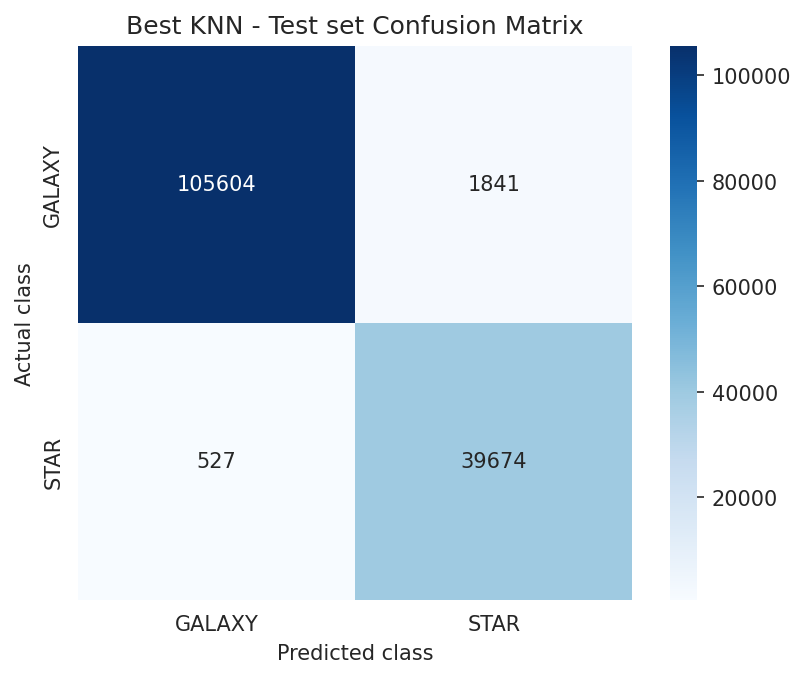

In [32]:
plot_confusion("Best KNN - Test set", grid.best_estimator_, X_test_scaled, y_test)

### Grid search - k neigbours

In [33]:
k_range = list(range(1, 30))
param_grid = dict(n_neighbors=k_range)    
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', verbose = 2)
grid.fit(X_train_scaled, y_train)

print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 10 folds for each of 29 candidates, totalling 290 fits
[CV] END ......................................n_neighbors=1; total time=   5.3s
[CV] END ......................................n_neighbors=1; total time=   4.9s
[CV] END ......................................n_neighbors=1; total time=   4.9s
[CV] END ......................................n_neighbors=1; total time=   6.2s
[CV] END ......................................n_neighbors=1; total time=   6.7s
[CV] END ......................................n_neighbors=1; total time=   7.2s
[CV] END ......................................n_neighbors=1; total time=   6.7s
[CV] END ......................................n_neighbors=1; total time=   6.9s
[CV] END ......................................n_neighbors=1; total time=   6.7s
[CV] END ......................................n_neighbors=1; total time=   6.7s
[CV] END ......................................n_neighbors=2; total time=   8.3s
[CV] END .....................................

In [39]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 6}
Best estimator:  KNeighborsClassifier(n_neighbors=6)
Best score:  0.9828044147934559


In [34]:
result = results = pd.DataFrame(grid.cv_results_)


In [35]:
mean_test_scores = results['mean_test_score']
neighbors = results['param_n_neighbors']

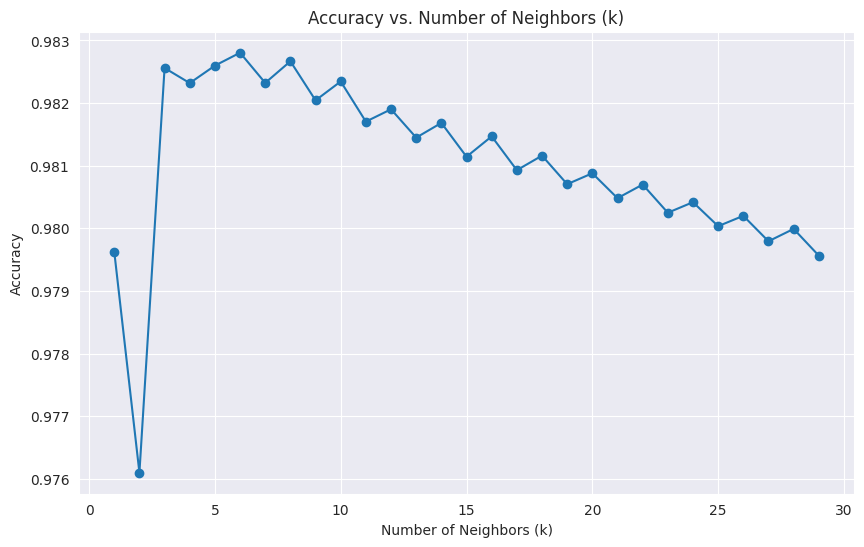

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(neighbors, mean_test_scores, marker='o')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()